In [2]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd

import random

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [4]:
train=pd.read_csv('../1. Task and Data/train.csv',sep='|')
test=pd.read_csv('../1. Task and Data/test.csv',sep='|')
#test = test.sample(50000);

train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

test['scannedLineItems'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['pricePerScannedLineItem'] = test['grandTotal'] / test['scannedLineItems']
test['scansWithoutRegistrationPerScannedLineItem'] = test['scansWithoutRegistration'] / test['scannedLineItems']
test['quantityModificationsPerScannedLineItem'] = test['quantityModifications'] / test['scannedLineItems']
test['lineItemVoidsPerSecond'] = test['lineItemVoids'] / test['totalScanTimeInSeconds']
test['scansWithoutRegistrationPerSecond'] = test['scansWithoutRegistration'] / test['totalScanTimeInSeconds']
test['quantityModificationsPerSecond'] = test['quantityModifications'] / test['totalScanTimeInSeconds']
test['secondsPerEuro'] = test['totalScanTimeInSeconds'] / test['grandTotal']
test['lineItemVoidsPerEuro'] = test['lineItemVoids'] / test['grandTotal']
test['scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / test['grandTotal']
test['quantityModificationsPerEuro'] = test['quantityModifications'] / test['grandTotal']

test.loc[test['grandTotal'] == 0.00, 'secondsPerEuro'] = test['totalScanTimeInSeconds'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'lineItemVoidsPerEuro'] = test['lineItemVoids'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'quantityModificationsPerEuro'] = test['quantityModifications'] / 0.01

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

# Cross validation
skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

# Split *train* dataset to feature and target sets 
X = train.drop('fraud',axis=1)
Y = train['fraud']

test['fraud'] = -1
train_test_combined = pd.concat([train, test], ignore_index=True)
X_train_test_combined = train_test_combined.drop('fraud',axis=1)
Y_train_test_combined = train_test_combined['fraud']
print(X_train_test_combined.shape, Y_train_test_combined.shape)

(500000, 20) (500000,)


In [3]:
# For reproducability of the results
np.random.seed(42)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer 

feature_scaler = MinMaxScaler()
X_train_test_combined = pd.DataFrame(feature_scaler.fit_transform(X_train_test_combined.values), columns=X_train_test_combined.columns, index=X_train_test_combined.index)

#feature_scaler = StandardScaler()
#X = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
#data_preparation = "StandardScaler"

#transformer = FunctionTransformer(np.log1p, validate=True)
#X_scaled = pd.DataFrame(transformer.transform(X), columns=X.columns, index=X.index)
#data_preparation = "LogScaler"

Explained variation per principal component: [0.16124041 0.1559011  0.14737624 0.13509126 0.13197732 0.11312753
 0.11161208]
Cumulative explained variation for 7 principal components: 0.9563259397521087


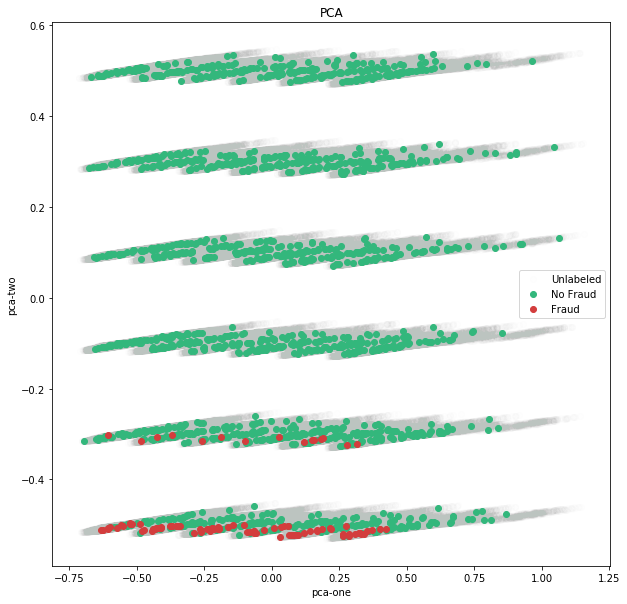

In [5]:
from sklearn.decomposition import PCA

X_train_test_combined_PCA = X_train_test_combined.copy()

pca = PCA(n_components=7)
pca_result = pca.fit_transform(X_train_test_combined_PCA)

X_train_test_combined_PCA['pca-one'] = pca_result[:,0]
X_train_test_combined_PCA['pca-two'] = pca_result[:,1] 
X_train_test_combined_PCA['pca-three'] = pca_result[:,2]

X_train_test_combined_PCA['pca-one'] = pca_result[:,0]
X_train_test_combined_PCA['pca-two'] = pca_result[:,1] 
X_train_test_combined_PCA['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Cumulative explained variation for 7 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))

plt.rcParams['figure.figsize'] = (10,10)

unlabeled=plt.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == -1].values, X_train_test_combined_PCA["pca-two"][Y_train_test_combined == -1].values, color='#bcc4c0', label="Unlabeled", alpha = 0.01)
nofraud=plt.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == 0], X_train_test_combined_PCA["pca-two"][Y_train_test_combined == 0], color='#33b77c', label="No Fraud", alpha = 1)
fraud=plt.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == 1], X_train_test_combined_PCA["pca-two"][Y_train_test_combined == 1], color='#d33d3d',label="Fraud", alpha = 1)
plt.legend(fancybox=True,handles=[unlabeled, nofraud,fraud])
plt.title("PCA")
plt.xlabel('pca-one')
plt.ylabel('pca-two')

plt.show()

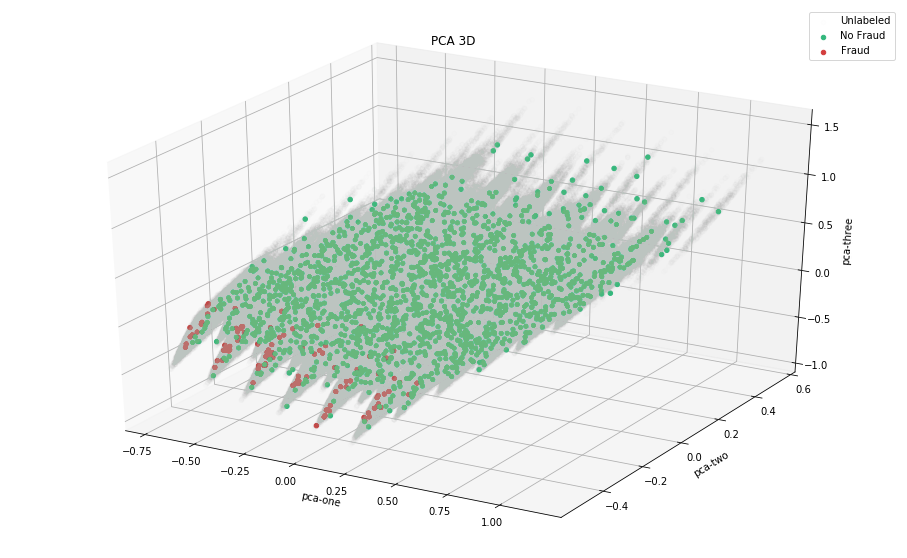

In [6]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')

unlabeled=ax.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == -1].values, X_train_test_combined_PCA["pca-two"][Y_train_test_combined == -1].values, X_train_test_combined_PCA["pca-three"][Y_train_test_combined == -1].values , color='#bcc4c0', label="Unlabeled", alpha = 0.01)
nofraud=ax.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == 0], X_train_test_combined_PCA["pca-two"][Y_train_test_combined == 0], X_train_test_combined_PCA["pca-three"][Y_train_test_combined == 0].values , color='#33b77c', label="No Fraud", alpha = 1)
fraud=ax.scatter(X_train_test_combined_PCA["pca-one"][Y_train_test_combined == 1], X_train_test_combined_PCA["pca-two"][Y_train_test_combined == 1], X_train_test_combined_PCA["pca-three"][Y_train_test_combined == 1].values , color='#d33d3d',label="Fraud", alpha = 1)
plt.legend(fancybox=True,handles=[unlabeled, nofraud,fraud])
plt.title("PCA 3D")
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [8]:
X_train_test_combined_tSNE = X_train_test_combined.copy()

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 500000 samples in 4.723s...
[t-SNE] Computed neighbors for 500000 samples in 166.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 500000
[t-SNE] Computed conditional probabilities for sample 2000 / 500000
[t-SNE] Computed conditional probabilities for sample 3000 / 500000
[t-SNE] Computed conditional probabilities for sample 4000 / 500000
[t-SNE] Computed conditional probabilities for sample 5000 / 500000
[t-SNE] Computed conditional probabilities for sample 6000 / 500000
[t-SNE] Computed conditional probabilities for sample 7000 / 500000
[t-SNE] Computed conditional probabilities for sample 8000 / 500000
[t-SNE] Computed conditional probabilities for sample 9000 / 500000
[t-SNE] Computed conditional probabilities for sample 10000 / 500000
[t-SNE] Computed conditional probabilities for sample 11000 / 500000
[t-SNE] Computed conditional probabilities for sample 12000 / 500000
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 135000 / 500000
[t-SNE] Computed conditional probabilities for sample 136000 / 500000
[t-SNE] Computed conditional probabilities for sample 137000 / 500000
[t-SNE] Computed conditional probabilities for sample 138000 / 500000
[t-SNE] Computed conditional probabilities for sample 139000 / 500000
[t-SNE] Computed conditional probabilities for sample 140000 / 500000
[t-SNE] Computed conditional probabilities for sample 141000 / 500000
[t-SNE] Computed conditional probabilities for sample 142000 / 500000
[t-SNE] Computed conditional probabilities for sample 143000 / 500000
[t-SNE] Computed conditional probabilities for sample 144000 / 500000
[t-SNE] Computed conditional probabilities for sample 145000 / 500000
[t-SNE] Computed conditional probabilities for sample 146000 / 500000
[t-SNE] Computed conditional probabilities for sample 147000 / 500000
[t-SNE] Computed conditional probabilities for sample 148000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 324000 / 500000
[t-SNE] Computed conditional probabilities for sample 325000 / 500000
[t-SNE] Computed conditional probabilities for sample 326000 / 500000
[t-SNE] Computed conditional probabilities for sample 327000 / 500000
[t-SNE] Computed conditional probabilities for sample 328000 / 500000
[t-SNE] Computed conditional probabilities for sample 329000 / 500000
[t-SNE] Computed conditional probabilities for sample 330000 / 500000
[t-SNE] Computed conditional probabilities for sample 331000 / 500000
[t-SNE] Computed conditional probabilities for sample 332000 / 500000
[t-SNE] Computed conditional probabilities for sample 333000 / 500000
[t-SNE] Computed conditional probabilities for sample 334000 / 500000
[t-SNE] Computed conditional probabilities for sample 335000 / 500000
[t-SNE] Computed conditional probabilities for sample 336000 / 500000
[t-SNE] Computed conditional probabilities for sample 337000 / 500000
[t-SNE] Computed con

[t-SNE] KL divergence after 250 iterations with early exaggeration: 149.054962
[t-SNE] KL divergence after 300 iterations: 9.885508
1 t-SNE done! Time elapsed: 3623.2540810108185 seconds
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 500000 samples in 1.592s...
[t-SNE] Computed neighbors for 500000 samples in 79.599s...
[t-SNE] Computed conditional probabilities for sample 1000 / 500000
[t-SNE] Computed conditional probabilities for sample 2000 / 500000
[t-SNE] Computed conditional probabilities for sample 3000 / 500000
[t-SNE] Computed conditional probabilities for sample 4000 / 500000
[t-SNE] Computed conditional probabilities for sample 5000 / 500000
[t-SNE] Computed conditional probabilities for sample 6000 / 500000
[t-SNE] Computed conditional probabilities for sample 7000 / 500000
[t-SNE] Computed conditional probabilities for sample 8000 / 500000
[t-SNE] Computed conditional probabilities for sample 9000 / 500000
[t-SNE] Computed conditional probabilities for sample 1

[t-SNE] Computed conditional probabilities for sample 149000 / 500000
[t-SNE] Computed conditional probabilities for sample 150000 / 500000
[t-SNE] Computed conditional probabilities for sample 151000 / 500000
[t-SNE] Computed conditional probabilities for sample 152000 / 500000
[t-SNE] Computed conditional probabilities for sample 153000 / 500000
[t-SNE] Computed conditional probabilities for sample 154000 / 500000
[t-SNE] Computed conditional probabilities for sample 155000 / 500000
[t-SNE] Computed conditional probabilities for sample 156000 / 500000
[t-SNE] Computed conditional probabilities for sample 157000 / 500000
[t-SNE] Computed conditional probabilities for sample 158000 / 500000
[t-SNE] Computed conditional probabilities for sample 159000 / 500000
[t-SNE] Computed conditional probabilities for sample 160000 / 500000
[t-SNE] Computed conditional probabilities for sample 161000 / 500000
[t-SNE] Computed conditional probabilities for sample 162000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 271000 / 500000
[t-SNE] Computed conditional probabilities for sample 272000 / 500000
[t-SNE] Computed conditional probabilities for sample 273000 / 500000
[t-SNE] Computed conditional probabilities for sample 274000 / 500000
[t-SNE] Computed conditional probabilities for sample 275000 / 500000
[t-SNE] Computed conditional probabilities for sample 276000 / 500000
[t-SNE] Computed conditional probabilities for sample 277000 / 500000
[t-SNE] Computed conditional probabilities for sample 278000 / 500000
[t-SNE] Computed conditional probabilities for sample 279000 / 500000
[t-SNE] Computed conditional probabilities for sample 280000 / 500000
[t-SNE] Computed conditional probabilities for sample 281000 / 500000
[t-SNE] Computed conditional probabilities for sample 282000 / 500000
[t-SNE] Computed conditional probabilities for sample 283000 / 500000
[t-SNE] Computed conditional probabilities for sample 284000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 425000 / 500000
[t-SNE] Computed conditional probabilities for sample 426000 / 500000
[t-SNE] Computed conditional probabilities for sample 427000 / 500000
[t-SNE] Computed conditional probabilities for sample 428000 / 500000
[t-SNE] Computed conditional probabilities for sample 429000 / 500000
[t-SNE] Computed conditional probabilities for sample 430000 / 500000
[t-SNE] Computed conditional probabilities for sample 431000 / 500000
[t-SNE] Computed conditional probabilities for sample 432000 / 500000
[t-SNE] Computed conditional probabilities for sample 433000 / 500000
[t-SNE] Computed conditional probabilities for sample 434000 / 500000
[t-SNE] Computed conditional probabilities for sample 435000 / 500000
[t-SNE] Computed conditional probabilities for sample 436000 / 500000
[t-SNE] Computed conditional probabilities for sample 437000 / 500000
[t-SNE] Computed conditional probabilities for sample 438000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 39000 / 500000
[t-SNE] Computed conditional probabilities for sample 40000 / 500000
[t-SNE] Computed conditional probabilities for sample 41000 / 500000
[t-SNE] Computed conditional probabilities for sample 42000 / 500000
[t-SNE] Computed conditional probabilities for sample 43000 / 500000
[t-SNE] Computed conditional probabilities for sample 44000 / 500000
[t-SNE] Computed conditional probabilities for sample 45000 / 500000
[t-SNE] Computed conditional probabilities for sample 46000 / 500000
[t-SNE] Computed conditional probabilities for sample 47000 / 500000
[t-SNE] Computed conditional probabilities for sample 48000 / 500000
[t-SNE] Computed conditional probabilities for sample 49000 / 500000
[t-SNE] Computed conditional probabilities for sample 50000 / 500000
[t-SNE] Computed conditional probabilities for sample 51000 / 500000
[t-SNE] Computed conditional probabilities for sample 52000 / 500000
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 168000 / 500000
[t-SNE] Computed conditional probabilities for sample 169000 / 500000
[t-SNE] Computed conditional probabilities for sample 170000 / 500000
[t-SNE] Computed conditional probabilities for sample 171000 / 500000
[t-SNE] Computed conditional probabilities for sample 172000 / 500000
[t-SNE] Computed conditional probabilities for sample 173000 / 500000
[t-SNE] Computed conditional probabilities for sample 174000 / 500000
[t-SNE] Computed conditional probabilities for sample 175000 / 500000
[t-SNE] Computed conditional probabilities for sample 176000 / 500000
[t-SNE] Computed conditional probabilities for sample 177000 / 500000
[t-SNE] Computed conditional probabilities for sample 178000 / 500000
[t-SNE] Computed conditional probabilities for sample 179000 / 500000
[t-SNE] Computed conditional probabilities for sample 180000 / 500000
[t-SNE] Computed conditional probabilities for sample 181000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 291000 / 500000
[t-SNE] Computed conditional probabilities for sample 292000 / 500000
[t-SNE] Computed conditional probabilities for sample 293000 / 500000
[t-SNE] Computed conditional probabilities for sample 294000 / 500000
[t-SNE] Computed conditional probabilities for sample 295000 / 500000
[t-SNE] Computed conditional probabilities for sample 296000 / 500000
[t-SNE] Computed conditional probabilities for sample 297000 / 500000
[t-SNE] Computed conditional probabilities for sample 298000 / 500000
[t-SNE] Computed conditional probabilities for sample 299000 / 500000
[t-SNE] Computed conditional probabilities for sample 300000 / 500000
[t-SNE] Computed conditional probabilities for sample 301000 / 500000
[t-SNE] Computed conditional probabilities for sample 302000 / 500000
[t-SNE] Computed conditional probabilities for sample 303000 / 500000
[t-SNE] Computed conditional probabilities for sample 304000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 411000 / 500000
[t-SNE] Computed conditional probabilities for sample 412000 / 500000
[t-SNE] Computed conditional probabilities for sample 413000 / 500000
[t-SNE] Computed conditional probabilities for sample 414000 / 500000
[t-SNE] Computed conditional probabilities for sample 415000 / 500000
[t-SNE] Computed conditional probabilities for sample 416000 / 500000
[t-SNE] Computed conditional probabilities for sample 417000 / 500000
[t-SNE] Computed conditional probabilities for sample 418000 / 500000
[t-SNE] Computed conditional probabilities for sample 419000 / 500000
[t-SNE] Computed conditional probabilities for sample 420000 / 500000
[t-SNE] Computed conditional probabilities for sample 421000 / 500000
[t-SNE] Computed conditional probabilities for sample 422000 / 500000
[t-SNE] Computed conditional probabilities for sample 423000 / 500000
[t-SNE] Computed conditional probabilities for sample 424000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 26000 / 500000
[t-SNE] Computed conditional probabilities for sample 27000 / 500000
[t-SNE] Computed conditional probabilities for sample 28000 / 500000
[t-SNE] Computed conditional probabilities for sample 29000 / 500000
[t-SNE] Computed conditional probabilities for sample 30000 / 500000
[t-SNE] Computed conditional probabilities for sample 31000 / 500000
[t-SNE] Computed conditional probabilities for sample 32000 / 500000
[t-SNE] Computed conditional probabilities for sample 33000 / 500000
[t-SNE] Computed conditional probabilities for sample 34000 / 500000
[t-SNE] Computed conditional probabilities for sample 35000 / 500000
[t-SNE] Computed conditional probabilities for sample 36000 / 500000
[t-SNE] Computed conditional probabilities for sample 37000 / 500000
[t-SNE] Computed conditional probabilities for sample 38000 / 500000
[t-SNE] Computed conditional probabilities for sample 39000 / 500000
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 148000 / 500000
[t-SNE] Computed conditional probabilities for sample 149000 / 500000
[t-SNE] Computed conditional probabilities for sample 150000 / 500000
[t-SNE] Computed conditional probabilities for sample 151000 / 500000
[t-SNE] Computed conditional probabilities for sample 152000 / 500000
[t-SNE] Computed conditional probabilities for sample 153000 / 500000
[t-SNE] Computed conditional probabilities for sample 154000 / 500000
[t-SNE] Computed conditional probabilities for sample 155000 / 500000
[t-SNE] Computed conditional probabilities for sample 156000 / 500000
[t-SNE] Computed conditional probabilities for sample 157000 / 500000
[t-SNE] Computed conditional probabilities for sample 158000 / 500000
[t-SNE] Computed conditional probabilities for sample 159000 / 500000
[t-SNE] Computed conditional probabilities for sample 160000 / 500000
[t-SNE] Computed conditional probabilities for sample 161000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 274000 / 500000
[t-SNE] Computed conditional probabilities for sample 275000 / 500000
[t-SNE] Computed conditional probabilities for sample 276000 / 500000
[t-SNE] Computed conditional probabilities for sample 277000 / 500000
[t-SNE] Computed conditional probabilities for sample 278000 / 500000
[t-SNE] Computed conditional probabilities for sample 279000 / 500000
[t-SNE] Computed conditional probabilities for sample 280000 / 500000
[t-SNE] Computed conditional probabilities for sample 281000 / 500000
[t-SNE] Computed conditional probabilities for sample 282000 / 500000
[t-SNE] Computed conditional probabilities for sample 283000 / 500000
[t-SNE] Computed conditional probabilities for sample 284000 / 500000
[t-SNE] Computed conditional probabilities for sample 285000 / 500000
[t-SNE] Computed conditional probabilities for sample 286000 / 500000
[t-SNE] Computed conditional probabilities for sample 287000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 394000 / 500000
[t-SNE] Computed conditional probabilities for sample 395000 / 500000
[t-SNE] Computed conditional probabilities for sample 396000 / 500000
[t-SNE] Computed conditional probabilities for sample 397000 / 500000
[t-SNE] Computed conditional probabilities for sample 398000 / 500000
[t-SNE] Computed conditional probabilities for sample 399000 / 500000
[t-SNE] Computed conditional probabilities for sample 400000 / 500000
[t-SNE] Computed conditional probabilities for sample 401000 / 500000
[t-SNE] Computed conditional probabilities for sample 402000 / 500000
[t-SNE] Computed conditional probabilities for sample 403000 / 500000
[t-SNE] Computed conditional probabilities for sample 404000 / 500000
[t-SNE] Computed conditional probabilities for sample 405000 / 500000
[t-SNE] Computed conditional probabilities for sample 406000 / 500000
[t-SNE] Computed conditional probabilities for sample 407000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 13000 / 500000
[t-SNE] Computed conditional probabilities for sample 14000 / 500000
[t-SNE] Computed conditional probabilities for sample 15000 / 500000
[t-SNE] Computed conditional probabilities for sample 16000 / 500000
[t-SNE] Computed conditional probabilities for sample 17000 / 500000
[t-SNE] Computed conditional probabilities for sample 18000 / 500000
[t-SNE] Computed conditional probabilities for sample 19000 / 500000
[t-SNE] Computed conditional probabilities for sample 20000 / 500000
[t-SNE] Computed conditional probabilities for sample 21000 / 500000
[t-SNE] Computed conditional probabilities for sample 22000 / 500000
[t-SNE] Computed conditional probabilities for sample 23000 / 500000
[t-SNE] Computed conditional probabilities for sample 24000 / 500000
[t-SNE] Computed conditional probabilities for sample 25000 / 500000
[t-SNE] Computed conditional probabilities for sample 26000 / 500000
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 138000 / 500000
[t-SNE] Computed conditional probabilities for sample 139000 / 500000
[t-SNE] Computed conditional probabilities for sample 140000 / 500000
[t-SNE] Computed conditional probabilities for sample 141000 / 500000
[t-SNE] Computed conditional probabilities for sample 142000 / 500000
[t-SNE] Computed conditional probabilities for sample 143000 / 500000
[t-SNE] Computed conditional probabilities for sample 144000 / 500000
[t-SNE] Computed conditional probabilities for sample 145000 / 500000
[t-SNE] Computed conditional probabilities for sample 146000 / 500000
[t-SNE] Computed conditional probabilities for sample 147000 / 500000
[t-SNE] Computed conditional probabilities for sample 148000 / 500000
[t-SNE] Computed conditional probabilities for sample 149000 / 500000
[t-SNE] Computed conditional probabilities for sample 150000 / 500000
[t-SNE] Computed conditional probabilities for sample 151000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 263000 / 500000
[t-SNE] Computed conditional probabilities for sample 264000 / 500000
[t-SNE] Computed conditional probabilities for sample 265000 / 500000
[t-SNE] Computed conditional probabilities for sample 266000 / 500000
[t-SNE] Computed conditional probabilities for sample 267000 / 500000
[t-SNE] Computed conditional probabilities for sample 268000 / 500000
[t-SNE] Computed conditional probabilities for sample 269000 / 500000
[t-SNE] Computed conditional probabilities for sample 270000 / 500000
[t-SNE] Computed conditional probabilities for sample 271000 / 500000
[t-SNE] Computed conditional probabilities for sample 272000 / 500000
[t-SNE] Computed conditional probabilities for sample 273000 / 500000
[t-SNE] Computed conditional probabilities for sample 274000 / 500000
[t-SNE] Computed conditional probabilities for sample 275000 / 500000
[t-SNE] Computed conditional probabilities for sample 276000 / 500000
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 383000 / 500000
[t-SNE] Computed conditional probabilities for sample 384000 / 500000
[t-SNE] Computed conditional probabilities for sample 385000 / 500000
[t-SNE] Computed conditional probabilities for sample 386000 / 500000
[t-SNE] Computed conditional probabilities for sample 387000 / 500000
[t-SNE] Computed conditional probabilities for sample 388000 / 500000
[t-SNE] Computed conditional probabilities for sample 389000 / 500000
[t-SNE] Computed conditional probabilities for sample 390000 / 500000
[t-SNE] Computed conditional probabilities for sample 391000 / 500000
[t-SNE] Computed conditional probabilities for sample 392000 / 500000
[t-SNE] Computed conditional probabilities for sample 393000 / 500000
[t-SNE] Computed conditional probabilities for sample 394000 / 500000
[t-SNE] Computed conditional probabilities for sample 395000 / 500000
[t-SNE] Computed conditional probabilities for sample 396000 / 500000
[t-SNE] Computed con

[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.188683
[t-SNE] KL divergence after 300 iterations: 3.951992
5 t-SNE done! Time elapsed: 3208.8317313194275 seconds
[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 500000 samples in 1.646s...


MemoryError: 

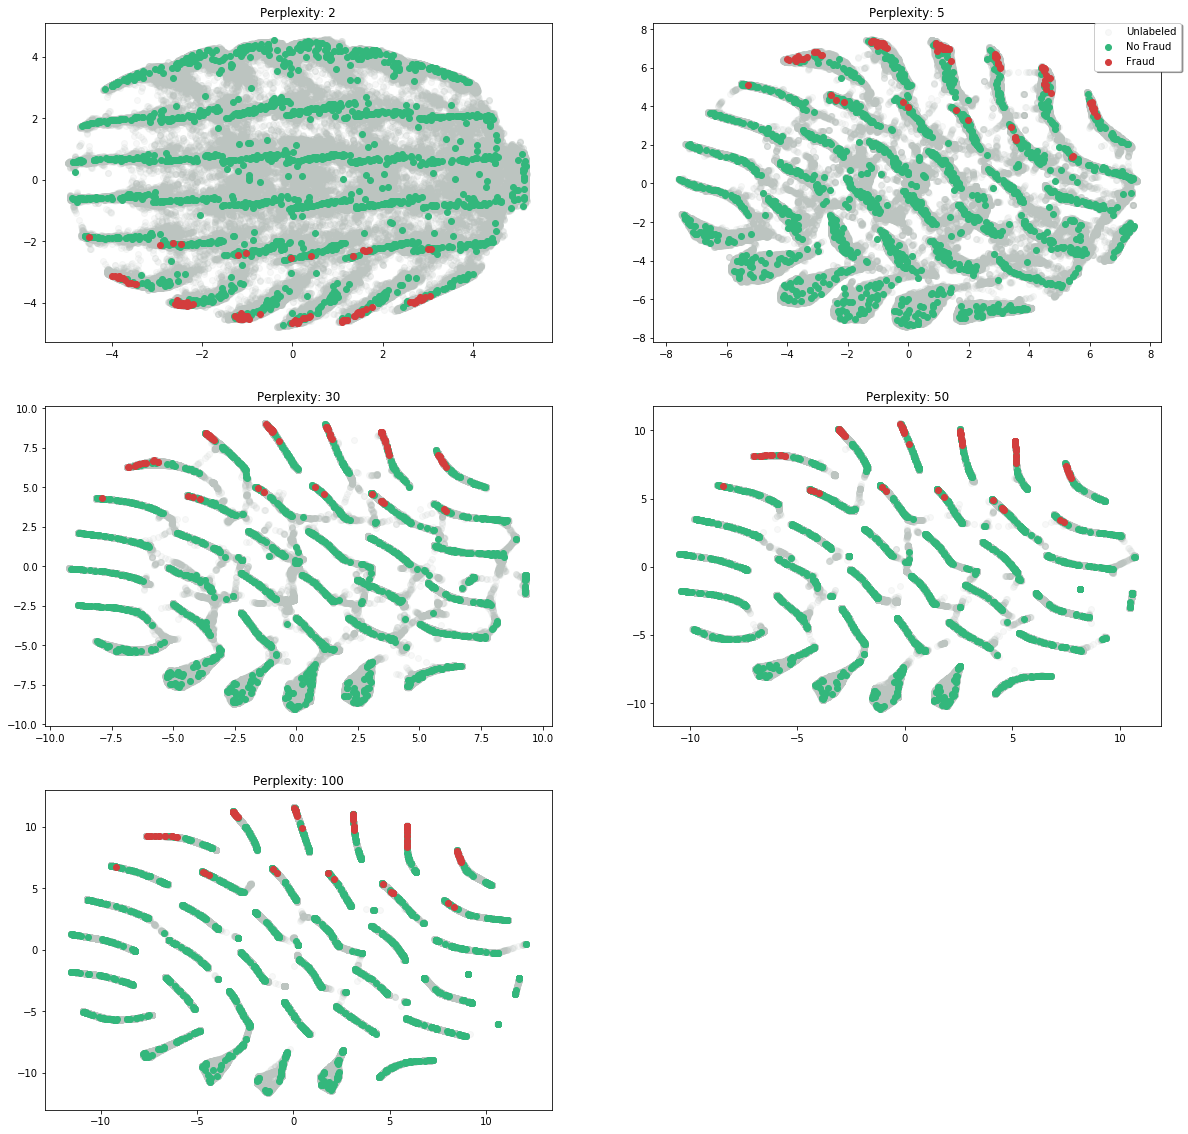

In [9]:
count=0
for perp in [2,5,30,50,100,400]:
    time_start = time.time()
    count+=1
    tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=300, init = 'pca', learning_rate=200)
    tsne_results = tsne.fit_transform(X_train_test_combined_tSNE)
    
    print(str(count)+' t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    X_train_test_combined_tSNE['tsne-one'] = tsne_results[:,0]
    X_train_test_combined_tSNE['tsne-two'] = tsne_results[:,1]
    
    plt.rcParams['figure.figsize'] = (20,20)
    ax2 = plt.subplot(3, 2, count)
    plt.title('Perplexity: '+str(perp))
    unlabeled=plt.scatter(X_train_test_combined_tSNE["tsne-one"][Y_train_test_combined == -1].values, X_train_test_combined_tSNE["tsne-two"][Y_train_test_combined == -1].values, color='#bcc4c0', label="Unlabeled", alpha = 0.1)
    nofraud=plt.scatter(X_train_test_combined_tSNE["tsne-one"][Y_train_test_combined == 0], X_train_test_combined_tSNE["tsne-two"][Y_train_test_combined == 0],label="No Fraud", color='#33b77c')
    fraud=plt.scatter(X_train_test_combined_tSNE["tsne-one"][Y_train_test_combined == 1], X_train_test_combined_tSNE["tsne-two"][Y_train_test_combined == 1],label="Fraud", color='#d33d3d')
    if(count==2):
        plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0,fancybox=True, shadow=True,handles=[unlabeled, nofraud,fraud])

plt.show()

In [ ]:
X_train_test_combined_tSNE3d = X_train_test_combined.copy()

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=300, init = 'pca', learning_rate=200)
tsne_results = tsne.fit_transform(X_train_test_combined_tSNE3d)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

print(tsne_results[:,0])

X_train_test_combined_tSNE3d['tsne-one'] = tsne_results[:,0]
X_train_test_combined_tSNE3d['tsne-two'] = tsne_results[:,1]
X_train_test_combined_tSNE3d['tsne-three'] = tsne_results[:,2]

ax = plt.figure(figsize=(20,20)).gca(projection='3d')
plt.title('tSNE-3D, Perplexity: 30')
unlabeled=ax.scatter(X_train_test_combined_tSNE3d["tsne-one"][Y_train_test_combined == -1].values, X_train_test_combined_tSNE3d["tsne-two"][Y_train_test_combined == -1].values,X_train_test_combined_tSNE3d["tsne-three"][Y_train_test_combined == -1].values, color='#bcc4c0', label="Unlabeled", alpha = 0.1)
nofraud=ax.scatter(X_train_test_combined_tSNE3d["tsne-one"][Y_train_test_combined == 0].values, X_train_test_combined_tSNE3d["tsne-two"][Y_train_test_combined == 0].values,X_train_test_combined_tSNE3d["tsne-three"][Y_train_test_combined == 0].values,label="No Fraud", color='#33b77c')
fraud=ax.scatter(X_train_test_combined_tSNE3d["tsne-one"][Y_train_test_combined == 1].values, X_train_test_combined_tSNE3d["tsne-two"][Y_train_test_combined == 1].values,X_train_test_combined_tSNE3d["tsne-three"][Y_train_test_combined == 1].values,label="Fraud", color='#d33d3d')
plt.legend(fancybox=True,handles=[unlabeled, nofraud,fraud])
ax.set_xlabel('tSNE-one')
ax.set_ylabel('tSNE-two')
ax.set_zlabel('tSNE-three')
plt.show()



In [ ]:
tsne_data = np.vstack((tsne_results.T, Y_train_test_combined)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
#sns.set_palette(sns.cubehelix_palette(3, rot=-.4))
flatui = ["#bcc4c0", "#33b77c", "#d33d3d"]
sns.set_palette(sns.color_palette(flatui))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plttitle="With perplexity = {0}, n_iter = {1}".format(30, 300)
plt.title(plttitle)   
plt.show()

In [ ]:
plt.figure(figsize=(16,7))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(df_subset["pca-one"], df_subset["pca-two"],  c=Y, cmap="cool", alpha=0.5)

ax2 = plt.subplot(1, 2, 2)
plt.scatter(df_subset["tsne-2d-one"], df_subset["tsne-2d-two"],  c=Y, cmap="cool", alpha=0.5)

plt.show()

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset["pca-one"], 
    ys=df_subset["pca-two"], 
    zs=df_subset["pca-three"], 
    c=Y, 
    cmap='cool'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
x = df_subset["pca-one"]
y = df_subset["pca-two"]

plt.scatter(x, y,  c=Y, cmap="cool", alpha=0.5)
plt.show()

In [ ]:
x = df_subset["tsne-2d-one"]
y = df_subset["tsne-2d-two"]

plt.scatter(x, y,  c=Y, cmap="cool", alpha=0.5)
plt.show()